**About the Project and Data**
<br>
<br>
This project will use linear regression modeling on data generated to simulate energy consumption data. The dataset was found on Kaggle at https://www.kaggle.com/datasets/govindaramsriram/energy-consumption-dataset-linear-regression/data. There, it is noted that the data was generated for the purpose of linear modeling but was done with restrictions in order to create life-like values for each field.
<br>
<br>
The data for each building has fields for building type (string), square footage (int), occupants (int), appliances (int), average temperature (float), day of the week (string), and energy consumption (float; target). The modeling process will compare lasso and ridge regression models from scikit-learn to choose the best model.
<br>
<br>
The training data has 1,000 rows of data and the testing data has 100 rows. There are three different types of buildings, each with a roughly equal share of the data. Since residential, commercial, and industrial buildings each have different natures, it would be better to split the data along those lines after loading.
<br>
<br>
**Preparing the Data**
<br>
<br>
The different building types will necessitate splitting the data into different categories. This can be done after the initial load of the datasets.

In [2]:
import pandas as pd
import numpy as np

# Loading the Data
train_data = pd.read_csv('train_energy_data.csv')
test_data = pd.read_csv('test_energy_data.csv')

# Splitting the Data by Building Type
res_train = train_data[train_data['Building Type'] == 'Residential']
res_train = res_train.drop(columns=['Building Type'])
res_test = test_data[test_data['Building Type'] == 'Residential']
res_test = res_test.drop(columns=['Building Type'])
res_test.index = np.arange(0, len(res_test))

comm_train = train_data[train_data['Building Type'] == 'Commercial']
comm_train = comm_train.drop(columns=['Building Type'])
comm_test = test_data[test_data['Building Type'] == 'Commercial']
comm_test = comm_test.drop(columns=['Building Type'])
comm_test.index = np.arange(0, len(comm_test))

ind_train = train_data[train_data['Building Type'] == 'Industrial']
ind_train = ind_train.drop(columns=['Building Type'])
ind_test = test_data[test_data['Building Type'] == 'Industrial']
ind_test = ind_test.drop(columns=['Building Type'])
ind_test.index = np.arange(0, len(ind_test))

With the data loaded and split, it needs to be prepared. Categorical fields need to be one-hot encoded and data needs to be standardized. Doing this for 6 datasets would be tedious, so using a helper function to do it would be better. The problem this poses though is that the standardizer would need to be fit using the entire training dataset to make sure the standardization is consistent across all building types. This can be done by initially preparing the entire training set by dummying and standardizing it. Then the standardizer can be applied within the helper function. Once that is done, the data can be split into feature and target sets and the two sets can be returned by the helper function.

In [4]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()

# Creating the standardizer using all of the training data
train_dummy = pd.get_dummies(train_data.drop(columns=['Building Type']), dtype='int')
standardizer.fit(train_dummy)

# Creating helper function to prepare data
def data_prepper(dataset):
    dummied = pd.get_dummies(dataset, dtype='int')
    scaled = pd.DataFrame(standardizer.transform(dummied), columns=dummied.columns)
    feats = scaled.drop(columns=['Energy Consumption'])
    targ = scaled['Energy Consumption']
    return feats, targ

In [5]:
# Applying the data_prepper function to the training and testing sets
res_train_feats, res_train_targ = data_prepper(res_train)
res_test_feats, res_test_targ = data_prepper(res_test)

comm_train_feats, comm_train_targ = data_prepper(comm_train)
comm_test_feats, comm_test_targ = data_prepper(comm_test)

ind_train_feats, ind_train_targ = data_prepper(ind_train)
ind_test_feats, ind_test_targ = data_prepper(ind_test)

**Creating the Models**
<br>
<br>
With the data now prepared, model creation can now begin. Lasso and Ridge models use an alpha value to govern regularization. Fine tuning the alpha parameter could be done with a grid search, but further division of the data into folds for cross validation would raise concerns with the amount of data for each fold. Scikit-Learn's GridSearchCV requires more than 1 fold in the data, so it will likely be easier to create two helper functions to create models with different alpha values and store the alpha value, model metrics, and model coefficients and intercepts into a table that can be given as the function's output for the lasso and ridge models separately.

In [7]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score as r2
from sklearn.metrics import root_mean_squared_error as rmse  
from sklearn.metrics import median_absolute_error as mdae  # (MdAE)

# Initializing Lasso and Ridge models as well as the alpha hyperparameter space
alpha = np.linspace(0.01, 1, 20)

In [8]:
# Creating a scoring function
def scorer(targs, preds):
    r2_score = r2(targs, preds)
    rmse_score = rmse(targs, preds)
    mdae_score = mdae(targs, preds)
    return r2_score, rmse_score, mdae_score
    

# Creating the Lasso modeling function
def lasso_explorer(alpha_space, train_feats, train_targ, test_feats, test_targ):
    result_table = pd.DataFrame()  # Initializing an empty dataframe to store scoring metrics
    preds_table = pd.DataFrame()  # Initializing an empty dataframe to store predicted values
    for value in alpha_space:  # Establishing loop through alpha values
        clf = Lasso(alpha=value)  # Creating the model
        fitted = clf.fit(train_feats, train_targ)  # Fitting the model
        preds = fitted.predict(test_feats)  # Making predictions using test features
        r2_score, rmse_score, mdae_score = scorer(test_targ, preds)  # Getting scoring metrics
        result_table['Lasso a'+str(np.round(value, decimals=2))] = [r2_score, rmse_score, mdae_score]
        preds_table['Lasso a'+str(np.round(value, decimals=2))] = preds
        
    result_table.index = ['r2_z', 'RMSE_z', 'MdAE_z']    
    result_table = result_table.transpose()  # Setting the scoring metrics as the columns
    result_table.index = np.round(alpha_space, decimals=2)  # Resetting the index to alpha
    return result_table, preds_table


# Creating the Ridge modeling function
def ridge_explorer(alpha_space, train_feats, train_targ, test_feats, test_targ):
    result_table = pd.DataFrame()  # Initializing an empty dataframe to store scoring metrics
    preds_table = pd.DataFrame()  # Initializing an empty dataframe to store predicted values
    for value in alpha_space:  # Establishing loop through alpha values
        clf = Ridge(alpha=value)  # Creating the model
        fitted = clf.fit(train_feats, train_targ)  # Fitting the model
        preds = fitted.predict(test_feats)  # Making predictions using test features
        r2_score, rmse_score, mdae_score = scorer(test_targ, preds)  # Getting scoring metrics
        result_table['Ridge a'+str(np.round(value, decimals=2))] = [r2_score, rmse_score, mdae_score]
        preds_table['Ridge a'+str(np.round(value, decimals=2))] = preds
    
    result_table.index = ['r2_z', 'RMSE_z', 'MdAE_z']    
    result_table = result_table.transpose()  # Setting the scoring metrics as the columns
    result_table.index = np.round(alpha_space, decimals=2)  # Resetting the index to alpha
    return result_table, preds_table

In [9]:
# Creating the Lasso Models
res_lasso_table, res_lasso_preds = lasso_explorer(alpha, res_train_feats, res_train_targ, res_test_feats, res_test_targ)
comm_lasso_table, comm_lasso_preds = lasso_explorer(alpha, comm_train_feats, comm_train_targ, comm_test_feats, comm_test_targ)
ind_lasso_table, ind_lasso_preds = lasso_explorer(alpha, ind_train_feats, ind_train_targ, ind_test_feats, ind_test_targ)

In [10]:
 # Creating the Ridge Models
res_ridge_table, res_ridge_preds = ridge_explorer(alpha, res_train_feats, res_train_targ, res_test_feats, res_test_targ)
comm_ridge_table, comm_ridge_preds = ridge_explorer(alpha, comm_train_feats, comm_train_targ, comm_test_feats, comm_test_targ)
ind_ridge_table, ind_ridge_preds = ridge_explorer(alpha, ind_train_feats, ind_train_targ, ind_test_feats, ind_test_targ)

**Evaluating the Lasso & Ridge Models**
<br>
<br>
With the models created and metrics found for the various values of alpha, we can plot the metrics to evaluate which model is best while also trying to avoid overfitting.

Text(0.5, 1.0, 'Lasso Regression r2 Values by Alpha Hyperparameter')

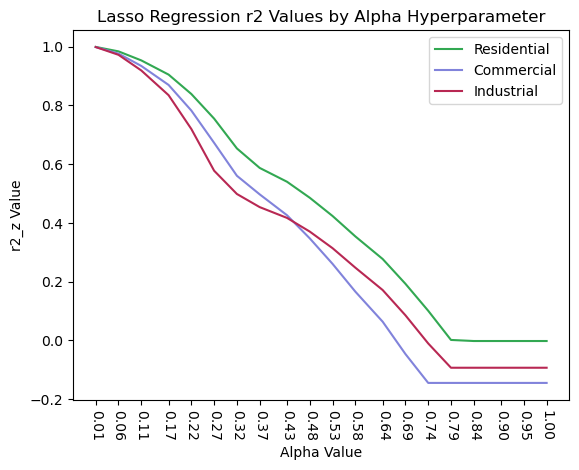

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the Lasso r2_z values
sns.lineplot(data=res_lasso_table, x=res_lasso_table.index, y='r2_z', color='#32a852', label='Residential')
sns.lineplot(data=comm_lasso_table, x=comm_lasso_table.index, y='r2_z', color='#8183db', label='Commercial')
sns.lineplot(data=ind_lasso_table, x=ind_lasso_table.index, y='r2_z', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('r2_z Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Lasso Regression r2 Values by Alpha Hyperparameter')

Text(0.5, 1.0, 'Ridge Regression r2 Values by Alpha Hyperparameter')

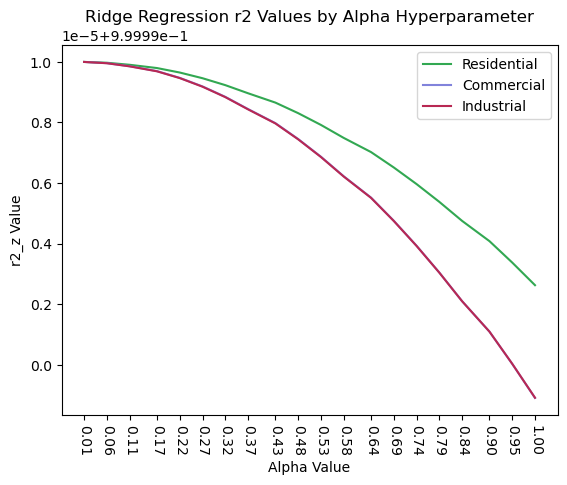

In [13]:
# Plotting the Ridge r2_z values
sns.lineplot(data=res_ridge_table, x=res_ridge_table.index, y='r2_z', color='#32a852', label='Residential')
sns.lineplot(data=comm_ridge_table, x=comm_ridge_table.index, y='r2_z', color='#8183db', label='Commercial')
sns.lineplot(data=ind_ridge_table, x=ind_ridge_table.index, y='r2_z', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('r2_z Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Ridge Regression r2 Values by Alpha Hyperparameter')

Text(0.5, 1.0, 'Lasso Regression RMSE by Alpha Hyperparameter')

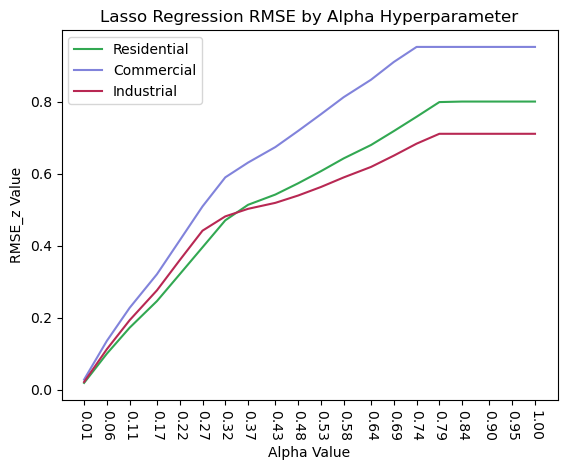

In [14]:
# Plotting the Lasso RMSE_z values
sns.lineplot(data=res_lasso_table, x=res_lasso_table.index, y='RMSE_z', color='#32a852', label='Residential')
sns.lineplot(data=comm_lasso_table, x=comm_lasso_table.index, y='RMSE_z', color='#8183db', label='Commercial')
sns.lineplot(data=ind_lasso_table, x=ind_lasso_table.index, y='RMSE_z', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('RMSE_z Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Lasso Regression RMSE by Alpha Hyperparameter')

Text(0.5, 1.0, 'Ridge Regression RMSE Values by Alpha Hyperparameter')

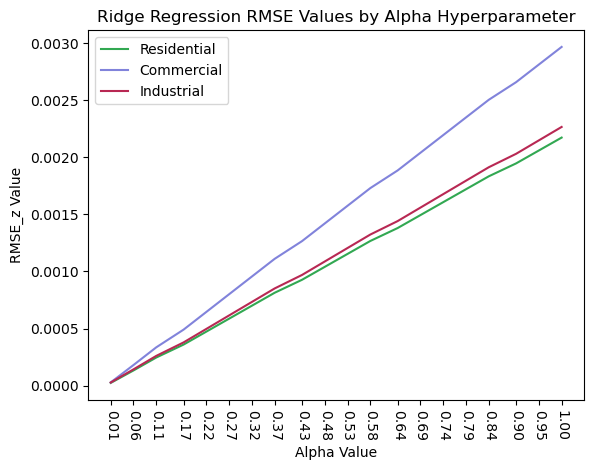

In [15]:
# Plotting the Ridge RMSE_z values
sns.lineplot(data=res_ridge_table, x=res_ridge_table.index, y='RMSE_z', color='#32a852', label='Residential')
sns.lineplot(data=comm_ridge_table, x=comm_ridge_table.index, y='RMSE_z', color='#8183db', label='Commercial')
sns.lineplot(data=ind_ridge_table, x=ind_ridge_table.index, y='RMSE_z', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('RMSE_z Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Ridge Regression RMSE Values by Alpha Hyperparameter')

Text(0.5, 1.0, 'Lasso Regression MdAE by Alpha Hyperparameter')

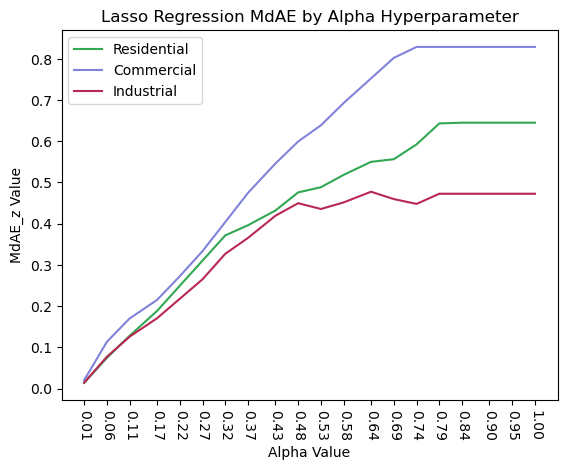

In [16]:
# Plotting the Lasso MdAE_z values
sns.lineplot(data=res_lasso_table, x=res_lasso_table.index, y='MdAE_z', color='#32a852', label='Residential')
sns.lineplot(data=comm_lasso_table, x=comm_lasso_table.index, y='MdAE_z', color='#8183db', label='Commercial')
sns.lineplot(data=ind_lasso_table, x=ind_lasso_table.index, y='MdAE_z', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('MdAE_z Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Lasso Regression MdAE by Alpha Hyperparameter')

Text(0.5, 1.0, 'Ridge Regression MdAE Values by Alpha Hyperparameter')

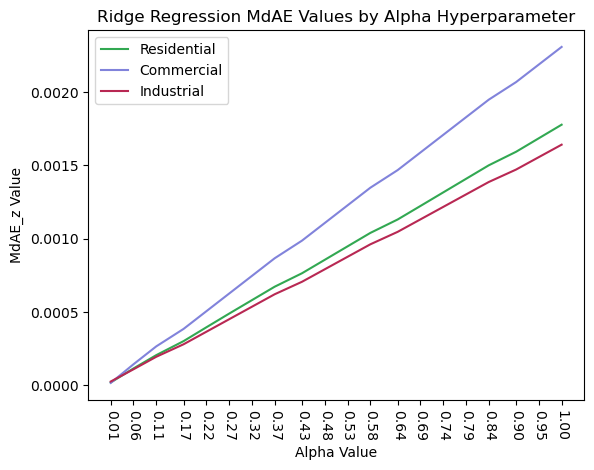

In [17]:
# Plotting the Ridge MdAE_z Values
sns.lineplot(data=res_ridge_table, x=res_ridge_table.index, y='MdAE_z', color='#32a852', label='Residential')
sns.lineplot(data=comm_ridge_table, x=comm_ridge_table.index, y='MdAE_z', color='#8183db', label='Commercial')
sns.lineplot(data=ind_ridge_table, x=ind_ridge_table.index, y='MdAE_z', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('MdAE_z Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Ridge Regression MdAE Values by Alpha Hyperparameter')

From the plots we can see that r2 values (indicating quality of fit and how much variance is explained by the model) are high and error values (RMSE and MdAE) are low for both the lasso and ridge models. As the value of alpha increases, r2 values quickly decrease and error values slightly increase. As alpha approaches 0, the model behaves more like a standard linear regression model. So making models using standard linear regression for comparison will also be a good idea.

In [19]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

# Fitting, Predicting with, and Scoring Residential Model
res_linreg = linreg.fit(res_train_feats, res_train_targ)
res_linreg_preds = pd.DataFrame(res_linreg.predict(res_test_feats), columns=['Predicted Value'])
res_linreg_r2, res_linreg_rmse, res_linreg_mdae = scorer(res_test_targ, res_linreg_preds)


# Fitting, Predicting with, and Scoring Commercial Model
comm_linreg = linreg.fit(comm_train_feats, comm_train_targ)
comm_linreg_preds = pd.DataFrame(comm_linreg.predict(comm_test_feats), columns=['Predicted Value'])
comm_linreg_r2, comm_linreg_rmse, comm_linreg_mdae = scorer(comm_test_targ, comm_linreg_preds)

# Fitting, Predicting with, and Scoring Industrial Model
ind_linreg = linreg.fit(ind_train_feats, ind_train_targ)
ind_linreg_preds = pd.DataFrame(ind_linreg.predict(ind_test_feats), columns=['Predicted Value'])
ind_linreg_r2, ind_linreg_rmse, ind_linreg_mdae = scorer(ind_test_targ, ind_linreg_preds)

# Bringing together the metrics
linreg_metrics = pd.DataFrame(
    {'r2_z' : [res_linreg_r2, comm_linreg_r2, ind_linreg_r2],
     'RMSE_z' : [res_linreg_rmse, comm_linreg_rmse, ind_linreg_rmse],
     'MdAE_z' : [res_linreg_mdae, res_linreg_mdae, res_linreg_mdae]},
    index=['Residential', 'Commercial', 'Industrial'])
linreg_metrics

,r2_z,RMSE_z,MdAE_z
Residential,1.0,0.000015,0.000012
Commercial,1.0,0.000015,0.000012
Industrial,1.0,0.000015,0.000012


It is worth noting that the error values are in terms of standard deviations of energy consumption from the complete training set. 

In [21]:
train_data['Energy Consumption'].std()

933.3130644692612

We can see that one standard deviation is around 933 kWhs of power. For ease of plotting and interpretation in Power BI or other visualization software, it would be wise to convert the predicted power consumption values, which are in terms of z-scores due to standardization, into real units, kWhs. We will just need to reverse the sstandardization for each set of predictions. However, since the standardizer was applied to the entire, dummied training dataset, it will want to use a dataset with 7 fields. This would require replacing the energy consumption values in the testing dataset with the predicted values for each model type. It would be easier to map a function across each set of predictions using the mean and standard deviations from the training data to undo the transformation. We can do the same process for the error values in the metrics dataframes as well.

In [23]:
# Acquiring mean and standard deviations of energy consumption in the training data
train_energy_mean = train_data['Energy Consumption'].mean()
train_energy_std = train_data['Energy Consumption'].std()

In [24]:
# Defining function to undo z-score standardization
def inverse_transformer(data):
    kwh = (data * train_energy_std) + train_energy_mean
    return kwh

In [25]:
# Mapping the inverse_transformer function to the prediction dataframes
res_lasso_preds_kwh = res_lasso_preds.map(lambda x: inverse_transformer(x))
res_ridge_preds_kwh = res_ridge_preds.map(lambda x: inverse_transformer(x))
res_linreg_preds_kwh = res_linreg_preds.map(lambda x: inverse_transformer(x))

comm_lasso_preds_kwh = comm_lasso_preds.map(lambda x: inverse_transformer(x))
comm_ridge_preds_kwh = comm_ridge_preds.map(lambda x: inverse_transformer(x))
comm_linreg_preds_kwh = comm_linreg_preds.map(lambda x: inverse_transformer(x))

ind_lasso_preds_kwh = ind_lasso_preds.map(lambda x: inverse_transformer(x))
ind_ridge_preds_kwh = ind_ridge_preds.map(lambda x: inverse_transformer(x))
ind_linreg_preds_kwh = ind_linreg_preds.map(lambda x: inverse_transformer(x))

In [26]:
def kwh_scorer(test_targ, preds):
    columns = preds.columns
    rmses = []
    mdaes = []
    r2s = []
    for column in columns:
        r2_score = r2(test_targ['Energy Consumption'], preds[column])
        r2s.append(r2_score)
        rmse_score = rmse(test_targ['Energy Consumption'], preds[column])
        rmses.append(rmse_score)
        mdae_score = mdae(test_targ['Energy Consumption'], preds[column])
        mdaes.append(mdae_score)
    return r2s, rmses, mdaes

In [27]:
# Adding kWh fields to metrics tables
res_lasso_table['r2_kWh'], res_lasso_table['RMSE_kWh'], res_lasso_table['MdAE_kWh'] = kwh_scorer(res_test, res_lasso_preds_kwh)
comm_lasso_table['r2_kWh'], comm_lasso_table['RMSE_kWh'], comm_lasso_table['MdAE_kWh'] = kwh_scorer(comm_test, comm_lasso_preds_kwh)
ind_lasso_table['r2_kWh'], ind_lasso_table['RMSE_kWh'], ind_lasso_table['MdAE_kWh'] = kwh_scorer(ind_test, ind_lasso_preds_kwh)

res_ridge_table['r2_kWh'], res_ridge_table['RMSE_kWh'], res_ridge_table['MdAE_kWh'] = kwh_scorer(res_test, res_ridge_preds_kwh)
comm_ridge_table['r2_kWh'], comm_ridge_table['RMSE_kWh'], comm_ridge_table['MdAE_kWh'] = kwh_scorer(comm_test, comm_ridge_preds_kwh)
ind_ridge_table['r2_kWh'], ind_ridge_table['RMSE_kWh'], ind_ridge_table['MdAE_kWh'] = kwh_scorer(ind_test, ind_ridge_preds_kwh)

linreg_metrics['r2_kWh'] = [r2(res_test['Energy Consumption'], res_linreg_preds_kwh),
                            r2(comm_test['Energy Consumption'], comm_linreg_preds_kwh),
                            r2(ind_test['Energy Consumption'], ind_linreg_preds_kwh)]
linreg_metrics['RMSE_kWh'] = [rmse(res_test['Energy Consumption'], res_linreg_preds_kwh),
                              rmse(comm_test['Energy Consumption'], comm_linreg_preds_kwh),
                              rmse(ind_test['Energy Consumption'], ind_linreg_preds_kwh)]
linreg_metrics['MdAE_kWh'] = [mdae(res_test['Energy Consumption'], res_linreg_preds_kwh),
                              mdae(comm_test['Energy Consumption'], comm_linreg_preds_kwh),
                              mdae(ind_test['Energy Consumption'], ind_linreg_preds_kwh)]

In [28]:
linreg_metrics

,r2_z,RMSE_z,MdAE_z,r2_kWh,RMSE_kWh,MdAE_kWh
Residential,1.0,0.000015,0.000012,1.0,0.437823,0.290034
Commercial,1.0,0.000015,0.000012,1.0,0.442511,0.400436
Industrial,1.0,0.000015,0.000012,1.0,0.369948,0.282566


With the predicted values now converted into real units, we will want to export them for proper use of visualization software for further investigation and analysis. Acquiring residual values would also be wise. This can be done with another helper function.

In [30]:
# Exporting Test and predicted values to Excel
with pd.ExcelWriter('Predicted Energy Consumption Values.xlsx') as writer:
    res_test['Energy Consumption'].to_excel(writer, sheet_name='Res Actual', index_label='Index')
    res_lasso_preds_kwh.to_excel(writer, sheet_name='Res Lasso Preds', index_label='Index')
    res_ridge_preds_kwh.to_excel(writer, sheet_name='Res Ridge Preds', index_label='Index')
    res_linreg_preds_kwh.to_excel(writer, sheet_name='Res LinReg Preds', index_label='Index')
    comm_test['Energy Consumption'].to_excel(writer, sheet_name='Comm Actual', index_label='Index')
    comm_lasso_preds_kwh.to_excel(writer, sheet_name='Comm Lasso Preds', index_label='Index')
    comm_ridge_preds_kwh.to_excel(writer, sheet_name='Comm Ridge Preds', index_label='Index')
    comm_linreg_preds_kwh.to_excel(writer, sheet_name='Comm LinReg Preds', index_label='Index')
    ind_test['Energy Consumption'].to_excel(writer, sheet_name='Ind Actual', index_label='Index')
    ind_lasso_preds_kwh.to_excel(writer, sheet_name='Ind Lasso Preds', index_label='Index')
    ind_ridge_preds_kwh.to_excel(writer, sheet_name='Ind Ridge Preds', index_label='Index')
    ind_linreg_preds_kwh.to_excel(writer, sheet_name='Ind LinReg Preds', index_label='Index')

In [31]:
# Exporting metric scores and model parameters to Excel
with pd.ExcelWriter('Model Metrics.xlsx') as writer:
    res_lasso_table.to_excel(writer, sheet_name='Res Lasso Metrics', index_label='Alpha')
    comm_lasso_table.to_excel(writer, sheet_name='Comm Lasso Metrics', index_label='Alpha')
    ind_lasso_table.to_excel(writer, sheet_name='Ind Lasso Metrics', index_label='Alpha')
    res_ridge_table.to_excel(writer, sheet_name='Res Ridge Metrics', index_label='Alpha')
    comm_ridge_table.to_excel(writer, sheet_name='Comm Ridge Metrics', index_label='Alpha')
    ind_ridge_table.to_excel(writer, sheet_name='Ind Ridge Metrics', index_label='Alpha')
    linreg_metrics.to_excel(writer, sheet_name='LinReg Metrics', index_label='Building Type')

In [32]:
# Writing the Residual Calculator Function
def residual_extractor(test_values, pred_values):
    residual_table = pd.DataFrame()
    col_names = pred_values.columns
    for column in col_names:
        residuals = test_values['Energy Consumption'] - pred_values[column]
        residual_table[column] = residuals
    return residual_table

In [33]:
# Creating the Residual dataframes
res_lasso_residuals = residual_extractor(res_test, res_lasso_preds_kwh)
res_ridge_residuals = residual_extractor(res_test, res_ridge_preds_kwh)
res_linreg_residuals = residual_extractor(res_test, res_linreg_preds_kwh)

comm_lasso_residuals = residual_extractor(comm_test, comm_lasso_preds_kwh)
comm_ridge_residuals = residual_extractor(comm_test, comm_ridge_preds_kwh)
comm_linreg_residuals = residual_extractor(comm_test, comm_linreg_preds_kwh)

ind_lasso_residuals = residual_extractor(ind_test, ind_lasso_preds_kwh)
ind_ridge_residuals = residual_extractor(ind_test, ind_ridge_preds_kwh)
ind_linreg_residuals = residual_extractor(ind_test, ind_linreg_preds_kwh)

In [34]:
# Exporting the residual dataframes to Excel
with pd.ExcelWriter('Model Residuals.xlsx') as writer:
    res_lasso_residuals.to_excel(writer, sheet_name='Res Lasso Residuals', index_label='Index')
    res_ridge_residuals.to_excel(writer, sheet_name='Res Ridge Residuals', index_label='Index')
    res_linreg_residuals.to_excel(writer, sheet_name='Res LinReg Residuals', index_label='Index')
    comm_lasso_residuals.to_excel(writer, sheet_name='Comm Lasso Residuals', index_label='Index')
    comm_ridge_residuals.to_excel(writer, sheet_name='Comm Ridge Residuals', index_label='Index')
    comm_linreg_residuals.to_excel(writer, sheet_name='Comm LinReg Residuals', index_label='Index')
    ind_lasso_residuals.to_excel(writer, sheet_name='Ind Lasso Residuals', index_label='Index')
    ind_ridge_residuals.to_excel(writer, sheet_name='Ind Ridge Residuals', index_label='Index')
    ind_linreg_residuals.to_excel(writer, sheet_name='Ind LinReg Residuals', index_label='Index')

With the predictions and matrics dataframes exported to Excel, work can begin on producing visualizations for reporting. Additional basic visualizations can be supplied below using data from the predictions.

Text(0, 0.5, 'Power Consumed in kWh')

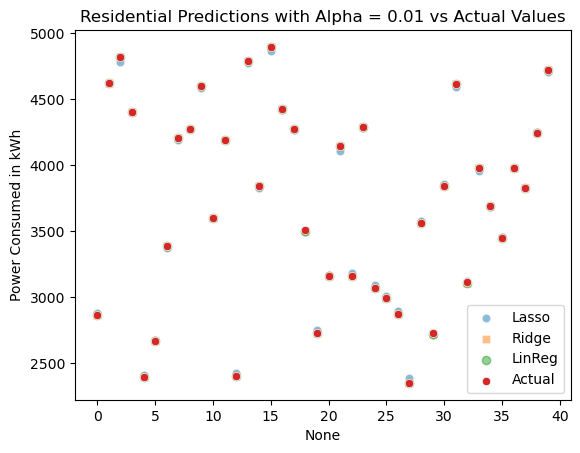

In [36]:
# Residential Plots
sns.scatterplot(data=res_lasso_preds_kwh, x=res_lasso_preds_kwh.index, y='Lasso a0.01', label='Lasso', alpha=0.5)
sns.scatterplot(data=res_ridge_preds_kwh, x=res_ridge_preds_kwh.index, y='Ridge a0.01', label='Ridge', alpha=0.5, marker='s')
plt.scatter(x=res_linreg_preds_kwh.index, y=res_linreg_preds_kwh, label='LinReg', alpha=0.5)
sns.scatterplot(data=res_test, x=res_test.index, y='Energy Consumption', label='Actual')
plt.title('Residential Predictions with Alpha = 0.01 vs Actual Values')
plt.ylabel('Power Consumed in kWh')

Text(0, 0.5, 'Power Consumed in kWh')

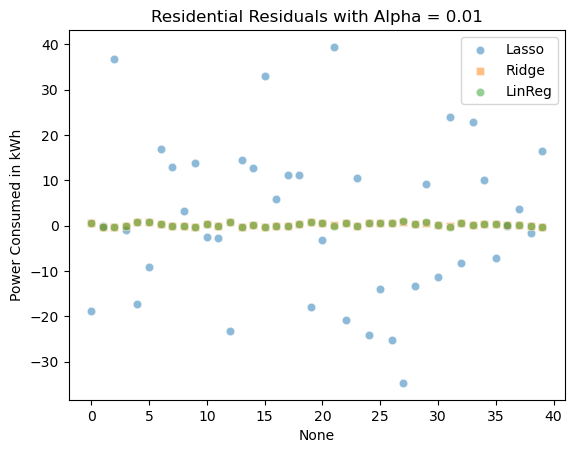

In [37]:
# Residential Residual Plots
sns.scatterplot(data=res_lasso_residuals, x=res_lasso_residuals.index, y='Lasso a0.01', label='Lasso', alpha=0.5)
sns.scatterplot(data=res_ridge_residuals, x=res_ridge_residuals.index, y='Ridge a0.01', label='Ridge', alpha=0.5, marker='s')
sns.scatterplot(data=res_linreg_residuals, x=res_linreg_residuals.index, y='Predicted Value', label='LinReg', alpha=0.5)
plt.title('Residential Residuals with Alpha = 0.01')
plt.ylabel('Power Consumed in kWh')

Text(0, 0.5, 'Power Consumed in kWh')

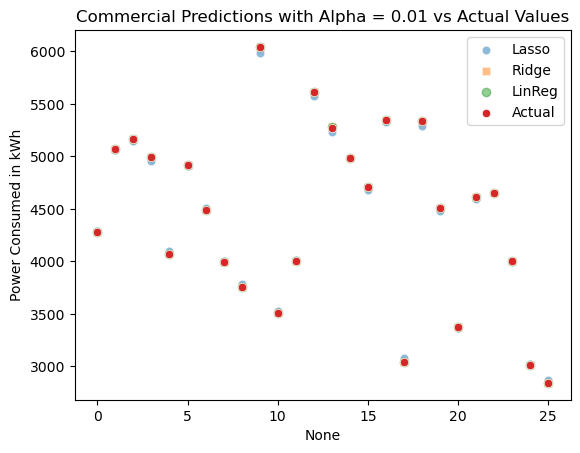

In [38]:
# Commercial Plots
sns.scatterplot(data=comm_lasso_preds_kwh, x=comm_lasso_preds_kwh.index, y='Lasso a0.01', label='Lasso', alpha=0.5)
sns.scatterplot(data=comm_ridge_preds_kwh, x=comm_ridge_preds_kwh.index, y='Ridge a0.01', label='Ridge', alpha=0.5, marker='s')
plt.scatter(x=comm_linreg_preds_kwh.index, y=comm_linreg_preds_kwh, label='LinReg', alpha=0.5)
sns.scatterplot(data=comm_test, x=comm_test.index, y='Energy Consumption', label='Actual')
plt.title('Commercial Predictions with Alpha = 0.01 vs Actual Values')
plt.ylabel('Power Consumed in kWh')

Text(0, 0.5, 'Power Consumed in kWh')

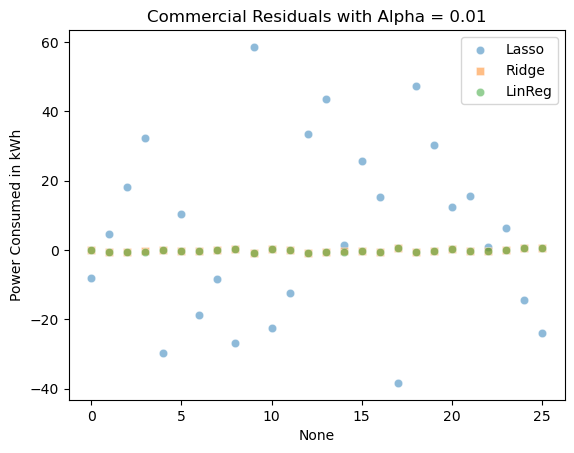

In [39]:
# Commercial Residual Plots
sns.scatterplot(data=comm_lasso_residuals, x=comm_lasso_residuals.index, y='Lasso a0.01', label='Lasso', alpha=0.5)
sns.scatterplot(data=comm_ridge_residuals, x=comm_ridge_residuals.index, y='Ridge a0.01', label='Ridge', alpha=0.5, marker='s')
sns.scatterplot(data=comm_linreg_residuals, x=comm_linreg_residuals.index, y='Predicted Value', label='LinReg', alpha=0.5)
plt.title('Commercial Residuals with Alpha = 0.01')
plt.ylabel('Power Consumed in kWh')

Text(0, 0.5, 'Power Consumed in kWh')

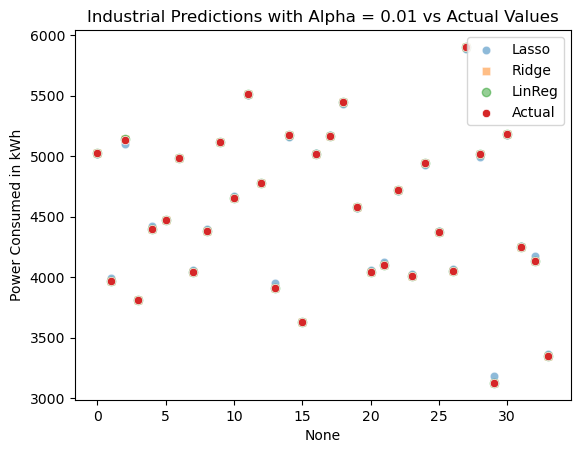

In [40]:
# Industrial Plots
sns.scatterplot(data=ind_lasso_preds_kwh, x=ind_lasso_preds_kwh.index, y='Lasso a0.01', label='Lasso', alpha=0.5)
sns.scatterplot(data=ind_ridge_preds_kwh, x=ind_ridge_preds_kwh.index, y='Ridge a0.01', label='Ridge', alpha=0.5, marker='s')
plt.scatter(x=ind_linreg_preds_kwh.index, y=ind_linreg_preds_kwh, label='LinReg', alpha=0.5)
sns.scatterplot(data=ind_test, x=ind_test.index, y='Energy Consumption', label='Actual')
plt.title('Industrial Predictions with Alpha = 0.01 vs Actual Values')
plt.ylabel('Power Consumed in kWh')

Text(0, 0.5, 'Power Consumed in kWh')

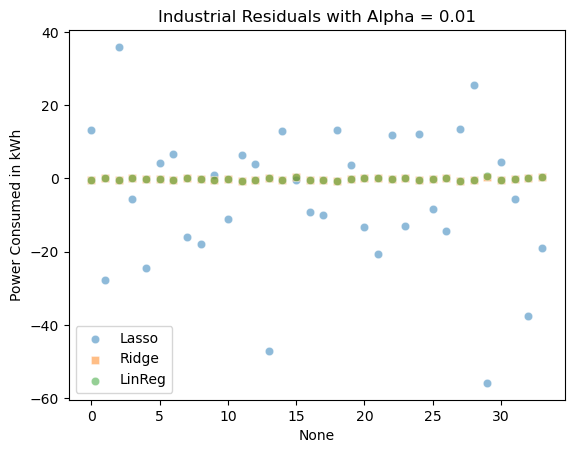

In [41]:
# Industrial Residual Plots
sns.scatterplot(data=ind_lasso_residuals, x=ind_lasso_residuals.index, y='Lasso a0.01', label='Lasso', alpha=0.5)
sns.scatterplot(data=ind_ridge_residuals, x=ind_ridge_residuals.index, y='Ridge a0.01', label='Ridge', alpha=0.5, marker='s')
sns.scatterplot(data=ind_linreg_residuals, x=ind_linreg_residuals.index, y='Predicted Value', label='LinReg', alpha=0.5)
plt.title('Industrial Residuals with Alpha = 0.01')
plt.ylabel('Power Consumed in kWh')

Text(0.5, 1.0, 'Lasso Regression RMSE by Alpha Hyperparameter')

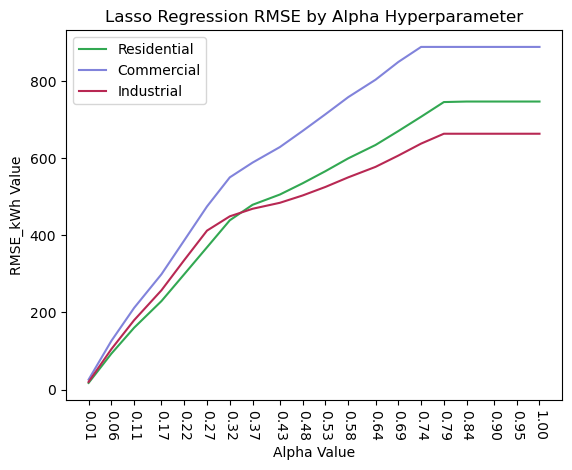

In [42]:
# Plotting the Lasso RMSE_kWh values
sns.lineplot(data=res_lasso_table, x=res_lasso_table.index, y='RMSE_kWh', color='#32a852', label='Residential')
sns.lineplot(data=comm_lasso_table, x=comm_lasso_table.index, y='RMSE_kWh', color='#8183db', label='Commercial')
sns.lineplot(data=ind_lasso_table, x=ind_lasso_table.index, y='RMSE_kWh', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('RMSE_kWh Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Lasso Regression RMSE by Alpha Hyperparameter')

Text(0.5, 1.0, 'Ridge Regression RMSE by Alpha Hyperparameter')

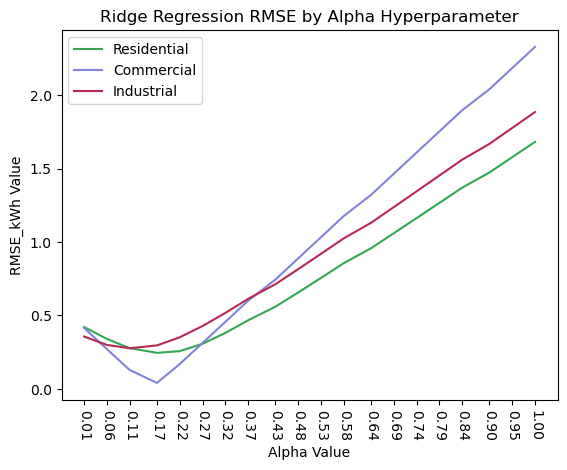

In [43]:
# Plotting the Ridge RMSE_kWh values
sns.lineplot(data=res_ridge_table, x=res_ridge_table.index, y='RMSE_kWh', color='#32a852', label='Residential')
sns.lineplot(data=comm_ridge_table, x=comm_ridge_table.index, y='RMSE_kWh', color='#8183db', label='Commercial')
sns.lineplot(data=ind_ridge_table, x=ind_ridge_table.index, y='RMSE_kWh', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('RMSE_kWh Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Ridge Regression RMSE by Alpha Hyperparameter')

Text(0.5, 1.0, 'Lasso Regression MdAE by Alpha Hyperparameter')

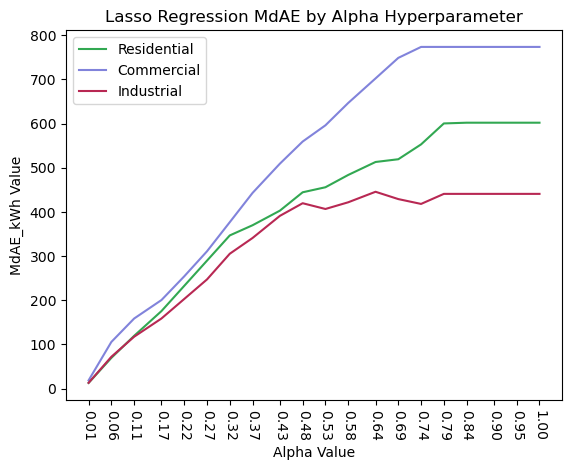

In [44]:
# Plotting the Lasso MdAE_kWh values
sns.lineplot(data=res_lasso_table, x=res_lasso_table.index, y='MdAE_kWh', color='#32a852', label='Residential')
sns.lineplot(data=comm_lasso_table, x=comm_lasso_table.index, y='MdAE_kWh', color='#8183db', label='Commercial')
sns.lineplot(data=ind_lasso_table, x=ind_lasso_table.index, y='MdAE_kWh', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('MdAE_kWh Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Lasso Regression MdAE by Alpha Hyperparameter')

Text(0.5, 1.0, 'Ridge Regression MdAE by Alpha Hyperparameter')

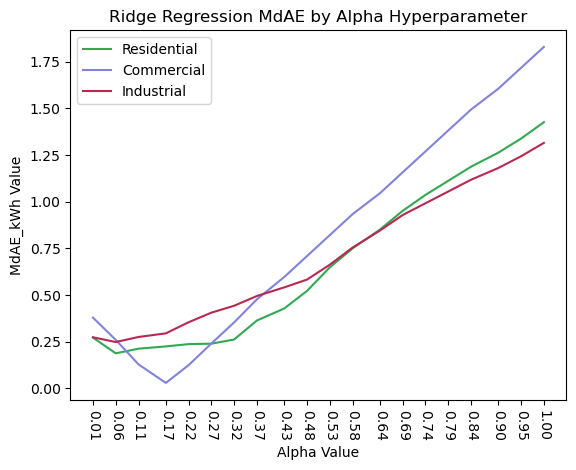

In [45]:
# Plotting the Ridge MdAE_kWh values
sns.lineplot(data=res_ridge_table, x=res_ridge_table.index, y='MdAE_kWh', color='#32a852', label='Residential')
sns.lineplot(data=comm_ridge_table, x=comm_ridge_table.index, y='MdAE_kWh', color='#8183db', label='Commercial')
sns.lineplot(data=ind_ridge_table, x=ind_ridge_table.index, y='MdAE_kWh', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('MdAE_kWh Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Ridge Regression MdAE by Alpha Hyperparameter')

Text(0.5, 1.0, 'Lasso Regression r2 Values by Alpha Hyperparameter')

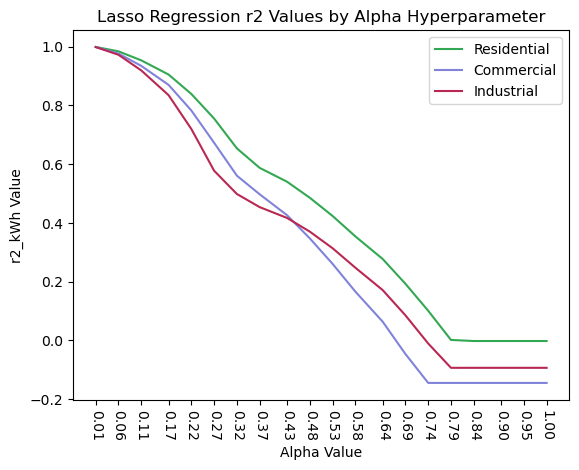

In [46]:
# Plotting the Lasso r2_kwh values
sns.lineplot(data=res_lasso_table, x=res_lasso_table.index, y='r2_kWh', color='#32a852', label='Residential')
sns.lineplot(data=comm_lasso_table, x=comm_lasso_table.index, y='r2_kWh', color='#8183db', label='Commercial')
sns.lineplot(data=ind_lasso_table, x=ind_lasso_table.index, y='r2_kWh', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('r2_kWh Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Lasso Regression r2 Values by Alpha Hyperparameter')

Text(0.5, 1.0, 'Ridge Regression r2 Values by Alpha Hyperparameter')

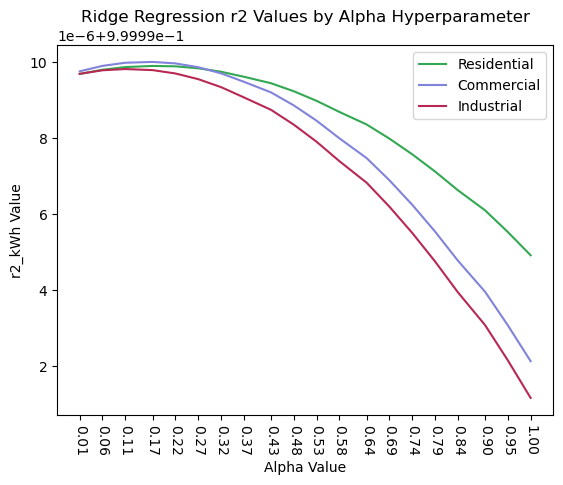

In [47]:
# Plotting the Ridge r2_kwh values
sns.lineplot(data=res_ridge_table, x=res_ridge_table.index, y='r2_kWh', color='#32a852', label='Residential')
sns.lineplot(data=comm_ridge_table, x=comm_ridge_table.index, y='r2_kWh', color='#8183db', label='Commercial')
sns.lineplot(data=ind_ridge_table, x=ind_ridge_table.index, y='r2_kWh', color='#b82853', label='Industrial')
plt.xlabel('Alpha Value'), plt.ylabel('r2_kWh Value')
plt.xticks(np.round(alpha, decimals=2), rotation=-90)
plt.title('Ridge Regression r2 Values by Alpha Hyperparameter')